# COnsigna de inicio : 
Descripción

*Descripción de la Competencia*

Pide a un comprador de vivienda que describa su casa ideal, y probablemente no comenzará con la altura del techo del sótano o la proximidad a una vía de ferrocarril este-oeste. Pero el conjunto de datos de esta competencia demuestra que hay muchos más factores que influyen en las negociaciones de precio que el número de dormitorios o una cerca blanca.

Con 79 variables explicativas que describen (casi) todos los aspectos de las viviendas residenciales en Ames, Iowa, esta competencia te reta a predecir el precio final de cada casa.

Habilidades a Practicar

-Ingeniería de características creativa

-Técnicas avanzadas de regresión como bosques aleatorios y boosting de gradiente

*Agradecimientos*

El conjunto de datos de viviendas de Ames fue compilado por Dean De Cock para su uso en educación en ciencia de datos. Es una alternativa increíble para los científicos de datos que buscan una versión modernizada y ampliada del frecuentemente citado conjunto de datos de viviendas de Boston.

Evaluación

Objetivo

Tu tarea es predecir el precio de venta de cada casa. Para cada Id en el conjunto de prueba, debes predecir el valor de la variable SalePrice.

Métrica

Las presentaciones se evalúan en función del Error Cuadrático Medio (RMSE) entre el logaritmo del valor predicho y el logaritmo del precio de venta observado. (Tomar logaritmos significa que los errores en la predicción de casas caras y baratas afectarán el resultado por igual.)

# en este notebook aplicaremos feature enginering

In [46]:
def plot_error_distribution(y_true, y_pred):
    """
    Esta función toma los valores verdaderos y las predicciones, calcula el error,
    y muestra un gráfico con un histograma de errores y una curva KDE de la densidad.
    
    :param y_true: Array de valores verdaderos.
    :param y_pred: Array de valores predichos.
    """
    
    
    # Calcular errores
    errors = y_true - y_pred.flatten() # El método flatten() convierte un array multidimensional (por ejemplo, una matriz de 2D) en un array de una sola dimensión (un vector).

    #     # Crear la figura y el eje principal
    #     fig, ax1 = plt.subplots()
    
    # Crear la figura y el eje principal con un tamaño de figura mayor
    fig, ax1 = plt.subplots(figsize=(10, 6))  # Ajusta el tamaño aquí (ancho, alto)

    # Crear el histograma en el eje principal
    sns.histplot(errors, bins=20, edgecolor='k', alpha=0.7, ax=ax1)
    ax1.set_xlabel('Error = y_true - y_pred')
    ax1.set_ylabel('Frecuencia')
    ax1.set_title('Distribución de Errores de Predicción')
    
     # Ajustar el rango del eje x
    ax1.set_xlim([errors.min(), errors.max()])  # Ajusta según el rango de errores
    
    # Crear un segundo eje que comparte el mismo eje x
    ax2 = ax1.twinx()

    # Crear el KDE en el segundo eje
    sns.kdeplot(errors, ax=ax2, color='r')
    ax2.set_ylabel('Densidad')

    # Modificar la grilla del eje y de la derecha
    ax2.grid(True, which='both', axis='y', color='r', alpha=0.3)

    # Mostrar el gráfico
    plt.show()


# Submissions : 


In [47]:
# predictions = np.exp(my_model.predict(X_test))

# output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
# output.to_csv('my_submission.csv', index=False)
# print("Your submission was successfully saved!")

# Import and configurations

In [48]:
import sys
import os

# Añadir la ruta al directorio del archivo .py
sys.path.append('/kaggle/input/libraries/utils_reg_eval')
import Utils # pronto cambiaremos el nombre a eval_reg_utils

In [49]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


These are only a couple ways you could use the principal components. You could also try clustering using one or more components. One thing to note is that PCA doesn't change the distance between points -- it's just like a rotation. So clustering with the full set of components is the same as clustering with the original features. Instead, pick some subset of components, maybe those with the most variance or the highest MI scores.

For further analysis, you might want to look at a correlation matrix for the dataset:


---

Aquí tienes la traducción del texto:

---

Estas son solo algunas formas en las que podrías usar los componentes principales. También podrías intentar realizar clustering utilizando uno o más componentes. Una cosa a tener en cuenta es que PCA no cambia la distancia entre puntos: es como una rotación. Así que hacer clustering con el conjunto completo de componentes es lo mismo que hacer clustering con las características originales. En su lugar, elige un subconjunto de componentes, tal vez aquellos con la mayor varianza o los puntajes de MI más altos.

Para un análisis más profundo, podrías querer ver una matriz de correlación para el conjunto de datos:

---

# df: load_df() # paracargar df_train y df_test

In [50]:
import pandas as pd

def load_df():
    df_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col ='Id')
    df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = 'Id')
   
    return df_train,df_test

df_train, df_test = load_df()

X = df_train
y = df_train.pop("SalePrice")


# Analizamos nuestra variable objetivo - Feature enginering

Distribucion de precios de venta de las casas - Sesgo a la izquierda

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


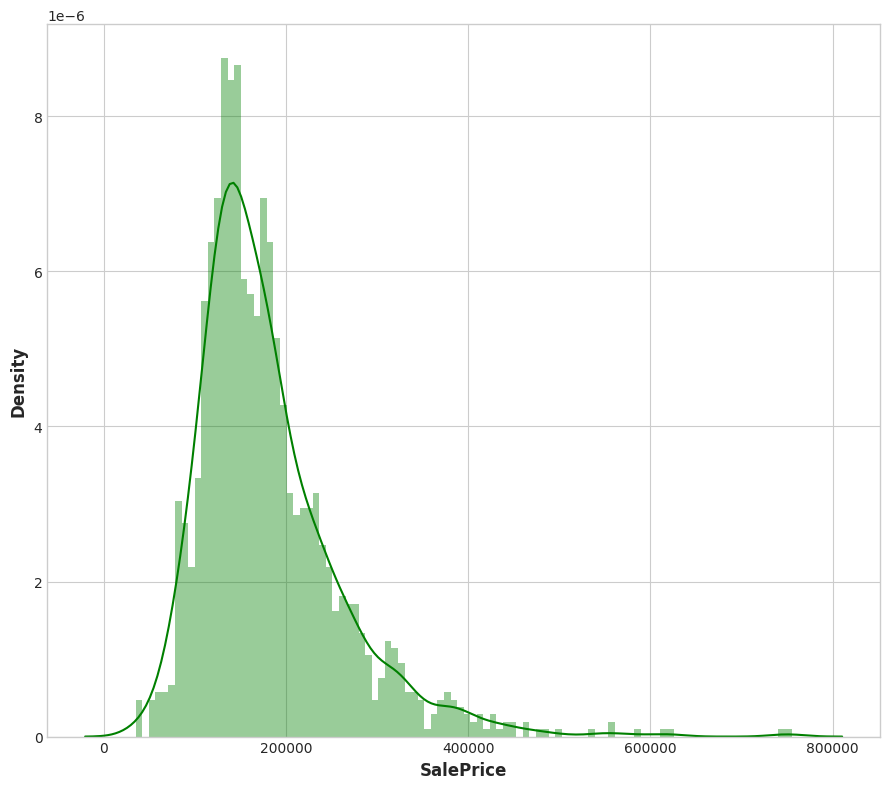

In [51]:
print(y.describe())
plt.figure(figsize=(9, 8))
sns.distplot(y, color='g', bins=100, hist_kws={'alpha': 0.4});

La transformación logarítmica es una técnica común para corregir sesgos a la izquierda. Al aplicar la función logarítmica, se reduce la diferencia entre los valores altos y bajos y acercar la distribución a una forma más normal

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64


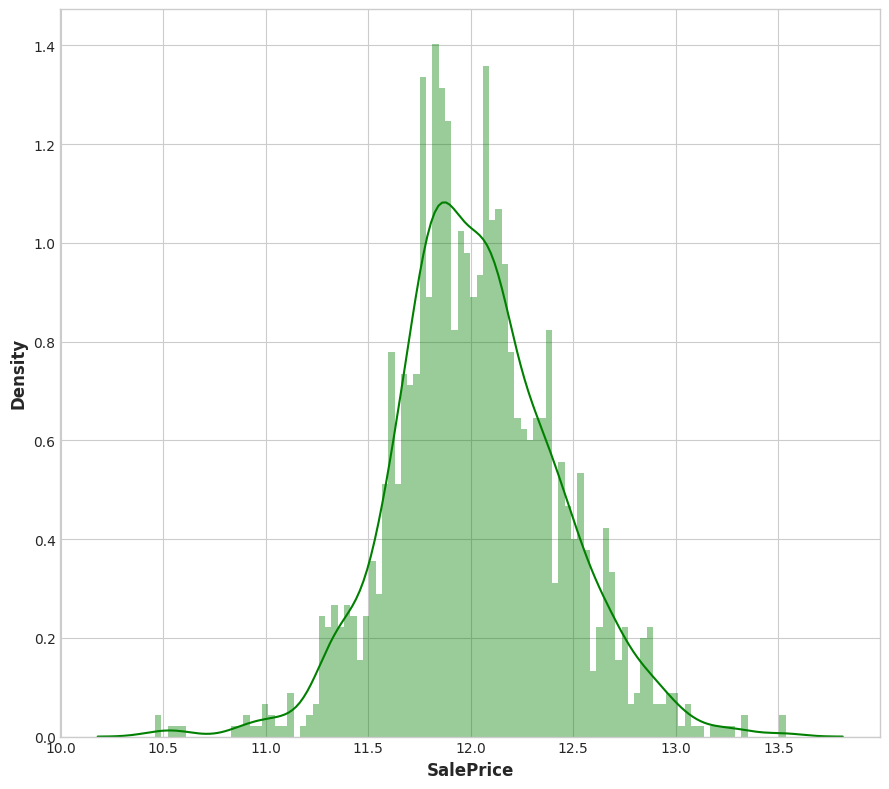

In [52]:
# Aplicar la transformación logarítmica
y_ = np.log(y)  # np.log1p maneja log(1 + x), útil si hay valores cero en los datos # lo usaremos para el entrenamiento

print(y_.describe())
plt.figure(figsize=(9, 8))
sns.distplot(y_, color='g', bins=100, hist_kws={'alpha': 0.4});
# Vamos a entrenar a los modelos con ello

# Dividimos los datos

## def: obtener_datos_reg(X,y, train_size=0.8, random_state=1) # para partir los datos automaticamente de nuestro df

In [53]:
from sklearn.model_selection import train_test_split

def obtener_datos_reg(X,y, train_size=0.8, random_state=1):

    # Primera división: conjunto de prueba
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, train_size=train_size, random_state=random_state)

    # Segunda división: conjunto de validación
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=train_size, random_state=random_state)

    total = X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]

    def porcent(num):
        result = num/total * 100 
        return f"{int(result)}%"

    print("el total de filas es : ", total)
    print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]}  -> {porcent(X_train.shape[0])}")
    print(f"Tamaño del conjunto de validación: {X_valid.shape[0]} -> {porcent(X_valid.shape[0])}")
    print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} -> {porcent(X_test.shape[0])}")

    return X_train, X_valid, y_train, y_valid, X_test, y_test

# prueba de uso
X_train, X_valid, y_train, y_valid, X_test, y_test = obtener_datos_reg(X,y)

y_train.head()

el total de filas es :  1460
Tamaño del conjunto de entrenamiento: 934  -> 63%
Tamaño del conjunto de validación: 234 -> 16%
Tamaño del conjunto de prueba: 292 -> 20%


Id
616     137500
1008     88000
507     215000
1355    235000
918     135000
Name: SalePrice, dtype: int64

In [54]:
y_train.head()

Id
616     137500
1008     88000
507     215000
1355    235000
918     135000
Name: SalePrice, dtype: int64

# Preprocesamos - scikit learn utils: 



In [55]:
# from sklearn import set_config
# set_config(transform_output="default")

# funciones de evaluacion

## def: eval_reg(model) # para evaluar 

In [56]:
def eval_reg(model):
    final_pipeline = model
#     final_pipeline.fit(X_train, y_train)

    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    # Evaluate on the validation set
    valid_preds = final_pipeline.predict(X_valid)
    valid_r2 = r2_score(y_valid, valid_preds)
    valid_mae = mean_absolute_error(y_valid, valid_preds)
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))

    print("Validation R^2: ", valid_r2)
    print("Validation MAE: ", valid_mae)
    print("Validation RMSE: ", valid_rmse)

    # Evaluate on the test set
    test_preds = final_pipeline.predict(X_test)
    test_r2 = r2_score(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    print("Test R^2 : ", test_r2)
    print("Test MAE : ", test_mae)
    print("Test RMSE : ", test_rmse)
    
    

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def log_val_reg(my_pipeline): # siendo my_pipeline = model de la pipeline 
    # Entrena el modelo con la transformación logarítmica
    final_pipeline = my_pipeline
    final_pipeline.fit(X_train, np.log(y_train))

    # Realizar predicciones en el conjunto de validación
    valid_preds_log = final_pipeline.predict(X_valid)

    # Revertir la transformación logarítmica
    valid_preds = np.exp(valid_preds_log)

    # Calcular métricas en la escala original
    valid_r2 = r2_score(y_valid, valid_preds)
    valid_mae = mean_absolute_error(y_valid, valid_preds)
    valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_preds))

    print("Validation R^2: ", valid_r2)
    print("Validation MAE: ", valid_mae)
    print("Validation RMSE: ", valid_rmse)

    # Realizar predicciones en el conjunto de prueba
    test_preds_log = final_pipeline.predict(X_test)

    # Revertir la transformación logarítmica
    test_preds = np.exp(test_preds_log)

    # Calcular métricas en la escala original
    test_r2 = r2_score(y_test, test_preds)
    test_mae = mean_absolute_error(y_test, test_preds)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

    print("Test R^2 : ", test_r2)
    print("Test MAE : ", test_mae)
    print("Test RMSE : ", test_rmse)
    
# log_val_reg(my_pipeline)



# eval_reg(my_pipeline)

# # plot error distribution # Test
# final_pipeline = my_pipeline
# final_pipeline.fit(X_train, np.log(y_train))

# # Realizar predicciones en el conjunto de prueba
# test_preds_log = final_pipeline.predict(X_test)

# # Revertir la transformación logarítmica
# test_preds = np.exp(test_preds_log)

# plot_error_distribution(y_test, test_preds) 

# # aun predice valore extremos

In [57]:
import optuna
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_absolute_error, make_scorer


# BASE LINE

In [58]:
y_train

Id
616     137500
1008     88000
507     215000
1355    235000
918     135000
         ...  
933     320000
151     122000
314     375000
860     250000
97      214000
Name: SalePrice, Length: 934, dtype: int64

In [59]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
#     for colname in X.select_dtypes(["category"]):
#         X[colname] = X[colname].cat.codes
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    score = cross_val_score(
        model, X, log_y, cv=5, scoring="neg_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # El método .factorize se utiliza para codificar los valores de una serie o un DataFrame en etiquetas numéricas. Es útil cuando se desea convertir datos categóricos en datos numérico. ej [a,b,c,a,a,b]  [1,2,3,1,1,2]
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores)) # como range pero devuelve un array de numpy 
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    


# basic data preprocesing

## listamos columnas de baja y alta cardinalidad, siendo cardinalidad cantidad de valores unicos. a fin de establecer o one hot encoding  o ordinal encoding

# def: column_names

In [60]:
import pandas as pd

def column_names(df):
    # Verifica si df es un DataFrame
    if not isinstance(df, pd.DataFrame):
        raise ValueError("El argumento debe ser un DataFrame de Pandas.")
    
    numerical_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    high_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() >= 10 and df[cname].dtype == "object"]
    low_cardinality_cols = [cname for cname in df.columns if df[cname].nunique() < 10 and df[cname].dtype == "object"]
    
    print("Columnas numéricas:", numerical_cols, "\n\n")
    print("Columnas de alta cardinalidad:", high_cardinality_cols, "\n\n")
    print("Columnas de baja cardinalidad:", low_cardinality_cols, "\n\n")
    
    return numerical_cols, high_cardinality_cols, low_cardinality_cols

# Cargar los DataFrames
df_train, df_test = load_df()

# Llamar a column_names con el DataFrame de entrenamiento
n, h, l = column_names(df_train)


Columnas numéricas: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'] 


Columnas de alta cardinalidad: ['Neighborhood', 'Exterior1st', 'Exterior2nd'] 


Columnas de baja cardinalidad: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrica

## def: impute_none and impute_mean_count(df) --- imputacion basica-> 

In [61]:
def impute_none(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes(["category", "object"]):
        df[name] = df[name].fillna("None")
    return df

def impute_mean_count(df):
    # Imputar valores faltantes en columnas numéricas con el promedio
    for name in df.select_dtypes(include=["number"]).columns:
        mean_value = df[name].mean()
        df[name] = df[name].fillna(mean_value)
    
    # Imputar valores faltantes en columnas categóricas con la moda
    for name in df.select_dtypes(include=["category", "object"]).columns:
        mode_value = df[name].mode()[0]  # mode() devuelve una Serie, tomamos el primer valor
        df[name] = df[name].fillna(mode_value)


df_train, df_test = load_df()
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [62]:
# comprobamos si y tiene valores faltantes  # Dado que no lo hicimos directamente en el dataframe
y.isnull().sum()

0

In [63]:
df_train = impute_none(df_train)
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,None,None,None,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,None,None,None,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,None,None,None,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,None,None,None,0,12,2008,WD,Normal,250000


# Encoding

## def: one_hot_encode(df)   &&   ordinal_encode(df)

In [64]:
# df_train[l]
type(l)

list

In [65]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def one_hot_encode(df, categorical_cols = None):
    # Identificar las columnas categóricas
    if categorical_cols is None: 
        return print("Falta lista de columnas a encodear")
    else:
        categorical_cols = categorical_cols
    
    # Crear un objeto OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # sparse_output=False para obtener una matriz densa, drop='first' para evitar la trampa de la colinealidad
    
    # Ajustar y transformar las columnas categóricas
    encoded_cols = encoder.fit_transform(df[categorical_cols])
    
    # Crear un DataFrame con las columnas codificadas
    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    
    # Unir el DataFrame original con el DataFrame codificado
    df_encoded = df.drop(categorical_cols, axis=1).join(encoded_df)
    
    return df_encoded



from sklearn.preprocessing import OrdinalEncoder
import pandas as pd

def ordinal_encode(df, categorical_cols = None):
    # Identificar las columnas categóricas
    if categorical_cols is None: 
        return print("Falta lista de columnas a encodear")
    else:
        categorical_cols = categorical_cols
    
    # Crear un objeto OrdinalEncoder
    encoder = OrdinalEncoder()
    
    # Ajustar y transformar las columnas categóricas
    df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
    
    return df

from sklearn.preprocessing import StandardScaler
import pandas as pd

def standardize_features(df, numeric_cols=None):
    # Identificar las columnas numéricas
    if numeric_cols is None:
        print("se necesita lista de nombres de columna 'n' como parametro")
    
    # Crear un objeto StandardScaler
    scaler = StandardScaler()
    
    # Ajustar y transformar las columnas numéricas
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
    return df

df_train = one_hot_encode(df_train, l)
# df_train[l] = one_hot_encode(df_train[l])
df_train = ordinal_encode(df_train, h)
df_train

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,5.0,7,5,2003,2003,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,20,80.0,9600,24.0,6,8,1976,1976,8.0,8.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60,68.0,11250,5.0,7,5,2001,2002,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,70,60.0,9550,6.0,7,5,1915,1970,13.0,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,60,84.0,14260,15.0,8,5,2000,2000,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,8.0,6,5,1999,2000,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,20,85.0,13175,14.0,6,6,1978,1988,9.0,10.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1458,70,66.0,9042,6.0,7,9,1941,2006,5.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## def: main() # funcion que retorna x,y para poder evaluar rapidamente un resultado

In [66]:
def main():
    df_train, df_test = load_df()
    df_train = one_hot_encode(df_train, l)
    df_train = ordinal_encode(df_train, h)
    X = df_train
    y = df_train.pop('SalePrice')
    return X, y

# score_dataset
X,y = main()
score = score_dataset(X,y)
print(score)

0.1438110865861481


# Creacion de caracteristicas : Para predecir el precio de una casa, se puede crear una serie de características derivadas (ratios y otras transformaciones) que capturan información relevante de los datos proporcionados:

### 1. **Ratios y Proporciones Básicas**

- **Tamaño del Lote y Área Construida**:
  - **`LotArea` a `GrLivArea` Ratio**: La relación entre el tamaño del lote y el área de vida sobre el suelo. Esto puede ayudar a entender la densidad de construcción en el lote.
    ```python
    df['LotArea_to_GrLivArea'] = df['LotArea'] / df['GrLivArea']
    ```

- **Área de los Pisos**:
  - **`1stFlrSF` a `GrLivArea` Ratio**: La proporción del área del primer piso con respecto al área total de vida sobre el suelo.
    ```python
    df['1stFlrSF_to_GrLivArea'] = df['1stFlrSF'] / df['GrLivArea']
    ```

### 2. **Transformaciones Temporales**

- **Edad de la Casa y Remodelación**:
  - **`Age`**: Edad de la casa en años (año actual menos `YearBuilt`).
    ```python
    from datetime import datetime
    current_year = datetime.now().year
    df['Age'] = current_year - df['YearBuilt']
    ```

  - **`RemodelAge`**: Edad desde la última remodelación (si existe).
    ```python
    df['RemodelAge'] = df['YearSold'] - df['YearRemodAdd']
    ```

### 3. **Características de la Propiedad**

- **Área del Sótano**:
  - **`TotalBsmtSF` a `GrLivArea` Ratio**: La proporción del área del sótano con respecto al área de vida sobre el suelo.
    ```python
    df['TotalBsmtSF_to_GrLivArea'] = df['TotalBsmtSF'] / df['GrLivArea']
    ```

- **Número de Baños por Área**:
  - **`FullBath` y `HalfBath` a `GrLivArea` Ratio**: Proporción del número total de baños con respecto al área total de vida.
    ```python
    df['TotalBaths_to_GrLivArea'] = (df['FullBath'] + df['HalfBath']) / df['GrLivArea']
    ```

### 4. **Características de la Ubicación**

- **Proximidad a Zonas Comerciales o Industriales**:
  - **`MSZoning`**: Codificar el tipo de zonificación con variables dummy para cada tipo de zonificación.
    ```python
    df = pd.get_dummies(df, columns=['MSZoning'], drop_first=True)
    ```

### 5. **Condiciones y Calidad**

- **Calidad del Hogar**:
  - **`OverallQual`**: Puede ser útil como una característica numérica o categorizarla en rangos para ver el impacto de la calidad en el precio.

- **Calidad de la Cocina**:
  - **`KitchenQual`**: Codificar como variables dummy.
    ```python
    df = pd.get_dummies(df, columns=['KitchenQual'], drop_first=True)
    ```

### 6. **Otras Transformaciones Útiles**

- **Número de Características**:
  - **`TotRmsAbvGrd` a `GrLivArea` Ratio**: La proporción del número total de habitaciones con respecto al área total de vida.
    ```python
    df['TotRmsAbvGrd_to_GrLivArea'] = df['TotRmsAbvGrd'] / df['GrLivArea']
    ```

- **Área de Porches y Decks**:
  - **`WoodDeckSF`, `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, `ScreenPorch`**: Sumar todas las áreas de porches y decks para una característica total.
    ```python
    df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    ```
```

### Resumen

Estos ratios y características adicionales pueden capturar relaciones y patrones en los datos que pueden ser útiles para predecir el precio de una casa.

In [67]:
df_train.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,5.0,7,5,2003,2003,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,20,80.0,9600,24.0,6,8,1976,1976,8.0,8.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,60,68.0,11250,5.0,7,5,2001,2002,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,70,60.0,9550,6.0,7,5,1915,1970,13.0,15.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,60,84.0,14260,15.0,8,5,2000,2000,12.0,13.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## def: crear_caract(df)


def crear_caract(df):

    # Calcular Edad de la Casa
    current_year = 2024
    df['Age'] = current_year - df['YearBuilt']

    # Crear ratios
    df['LotArea_to_GrLivArea'] = df['LotArea'] / df['GrLivArea']
    df['TotalBsmtSF_to_GrLivArea'] = df['TotalBsmtSF'] / df['GrLivArea']
    df['TotalBaths_to_GrLivArea'] = (df['FullBath'] + df['HalfBath']) / df['GrLivArea']
    df['TotalPorchSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
    
    #La idea es que una casa con alta calidad y un garaje grande podría tener un efecto combinado en el precio
    df['Qual_Garage_Interaction'] = df['OverallQual'] * df['GarageArea']
    
    #Transformación Polinómica capturamos relaciones no lineales creando características polinómicas
    df['Qual_Garage_Interaction_squared'] = df['Qual_Garage_Interaction'] ** 2
    df['OverallQual_Squared'] = df['OverallQual'] ** 2
    df['GarageArea_Cubed'] = df['GarageArea'] ** 3
    
    # Calcular el precio medio por vecindario
    # puede ayudar a capturar el efecto de las tendencias del vecindario sobre el precio.
    neighborhood_avg_price = df.groupby('Neighborhood')['SalePrice'].mean()
    df['Neighborhood_Avg_Price'] = df['Neighborhood'].map(neighborhood_avg_price)
    
    return df

df_train = crear_caract(df_train)
df_train['Age']



In [69]:
# re-Evaluamos el score

def main3():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    df_train = one_hot_encode(df_train, l)
    df_train = ordinal_encode(df_train, h)
    df_train = crear_caract(df_train)
    X = df_train
    y = df_train.pop('SalePrice')
    return X, y

# score_dataset
X,y = main3()
score = score_dataset(X,y)
print(score)

# Mejoro paso de 0.14671 a 0.14067 :
# Una mejora en la métrica de evaluación, especialmente una reducción en el error, indica que el modelo está
# capturando mejor las relaciones entre las características y el precio de la vivienda.

# y eso que aun no filtramos caracteristicas redundantes con el algoritmo de MUTUAL INFORMATION, 
# ni creamos una agrupacion por K-means, y tampoco aplicamos PCA

0.14067438458410272


# MI analisis : Mutual information algoritm

## df: make_mi_scores(X,y)

In [70]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize() # El método .factorize se utiliza para codificar los valores de una serie o un DataFrame en etiquetas numéricas. Es útil cuando se desea convertir datos categóricos en datos numérico. ej [a,b,c,a,a,b]  [1,2,3,1,1,2]
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores)) # como range pero devuelve un array de numpy 
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
mi_scores = make_mi_scores(X, y)
mi_scores

Qual_Garage_Interaction_squared    0.610421
Qual_Garage_Interaction            0.610421
OverallQual                        0.578775
OverallQual_Squared                0.578775
Neighborhood_Avg_Price             0.514176
                                     ...   
PoolQC_Fa                          0.000000
PoolQC_Gd                          0.000000
PoolQC_None                        0.000000
Functional_Sev                     0.000000
Condition1_RRAe                    0.000000
Name: MI Scores, Length: 220, dtype: float64

In [71]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]

# X = drop_uninformative(X, mi_scores)

# score_dataset(X, y)

In [72]:
# def listar_informativas(df, score):
mi_scores

Qual_Garage_Interaction_squared    0.610421
Qual_Garage_Interaction            0.610421
OverallQual                        0.578775
OverallQual_Squared                0.578775
Neighborhood_Avg_Price             0.514176
                                     ...   
PoolQC_Fa                          0.000000
PoolQC_Gd                          0.000000
PoolQC_None                        0.000000
Functional_Sev                     0.000000
Condition1_RRAe                    0.000000
Name: MI Scores, Length: 220, dtype: float64

In [73]:
def main4():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    return X, y

# score_dataset
X,y = main4()
score = score_dataset(X,y)
print(score)

# ok, el mejor valor de mi drop_uniformative, fue el de 0.0, cuando lo deje en 0.03 fue terrible el valor, aumento a 0.1536
# ahora con el 0.0 disminuyo nuestro score


0.13687711204063732


# Agrupamiento de caracteristicas. Feature enginering

# def: cluster_labels(df, features, n_clusters=20)

## Agrupamiento de caracteristicas en comun (en este caso area, tiempo, y lugar)

Agrupar características basadas en una característica común, como el área o pies cuadrados, es una estrategia efectiva para simplificar el modelo y capturar relaciones subyacentes.

In [74]:
cluster_features_ar = [
    "LotArea",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
]


cluster_features_temp = [
    "YearBuilt",
    "YearRemodAdd",
    "YrSold",
]

cluster_features_land = [
    "Neighborhood",
    "LotConfig",
    "LotShape",
    "LandContour",
]



def cluster_labels(df, features,  name_col = "Cluster", n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
#     X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new[name_col] = kmeans.fit_predict(X_scaled)
    return X_new

In [75]:
def main5():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
        
#     X = cluster_labels(X, cluster_features_land, name_col = 'Cluster_land', n_clusters = 10)
    
    # Conclusion, en este caso ningun cluster parece capturar relaciones utiles en los datos, al contrario parece 
    # ser contraproducente añadiendo ruido

    return X, y

# score_dataset
X,y = main5()
score = score_dataset(X,y)
print(score)

0.13687711204063732


In [76]:
def main4():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    return X, y

# score_dataset
X,y = main4()
score = score_dataset(X,y)
print(score)

# por el momento sigue siendo el mejor "main()"


0.13687711204063732


# PCA / Algoritmo PCA - analisis y creacion de dichas caracteristicas.

PCA mide en nivel de importancia en la estructura de los datos segun su varianza.

PCA (Análisis de Componentes Principales) mide la importancia de las direcciones en las que los datos tienen la mayor variabilidad.

los componentes principales son informativos porque proporcionan una forma eficiente de describir y entender la estructura de los datos, capturando la variabilidad máxima mientras eliminan la redundancia y la correlación entre características.




**Existe** 

Alta Varianza: Si un componente principal tiene alta varianza, significa que los datos están muy extendidos a lo largo de esa dirección, y esa dirección es muy informativa respecto a la estructura de los datos.

Baja Varianza: Si un componente principal tiene baja varianza, significa que los datos están menos extendidos a lo largo de 
esa dirección, y esa dirección aporta menos información sobre la estructura de los datos.




## def: apply_pca(X,sctandardize = True)

In [77]:
# definimos funcion para crear caracteristicas de "componentes principales"
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


# PCA: marco de accion
antes de aplicar el algoritmo de PCA queremos captar primero las caracteristicas mas correlacionadas entre todas, pero que asu vez tengan importancia segun el score del MI. 


- primero utilizando métodos como la información mutua (MI), que mide la relevancia de cada característica en relación con la variable objetivo

- luego ploteamos la matriz de correlacion, y evaluamos la correlacion entre estas caracteristicas cuyo MI score sea el mas alto. La matriz de correlación ayuda a identificar cuáles características están altamente correlacionadas, lo que indica redundancia.

Correlación entre Características: Luego, aplicas PCA para reducir la dimensionalidad de estas características. PCA combina las características originales en componentes principales, maximizando la varianza explicada.


In [78]:
df_mi_scores = pd.DataFrame(mi_scores)
print(df_mi_scores.head(10))
indices_10_primeros_lista = df_mi_scores.index[:10].tolist()
print(indices_10_primeros_lista)

                                 MI Scores
Qual_Garage_Interaction_squared   0.610421
Qual_Garage_Interaction           0.610421
OverallQual                       0.578775
OverallQual_Squared               0.578775
Neighborhood_Avg_Price            0.514176
Neighborhood                      0.513079
GarageArea_Cubed                  0.497256
GarageArea                        0.497256
GrLivArea                         0.432079
YearBuilt                         0.408409
['Qual_Garage_Interaction_squared', 'Qual_Garage_Interaction', 'OverallQual', 'OverallQual_Squared', 'Neighborhood_Avg_Price', 'Neighborhood', 'GarageArea_Cubed', 'GarageArea', 'GrLivArea', 'YearBuilt']


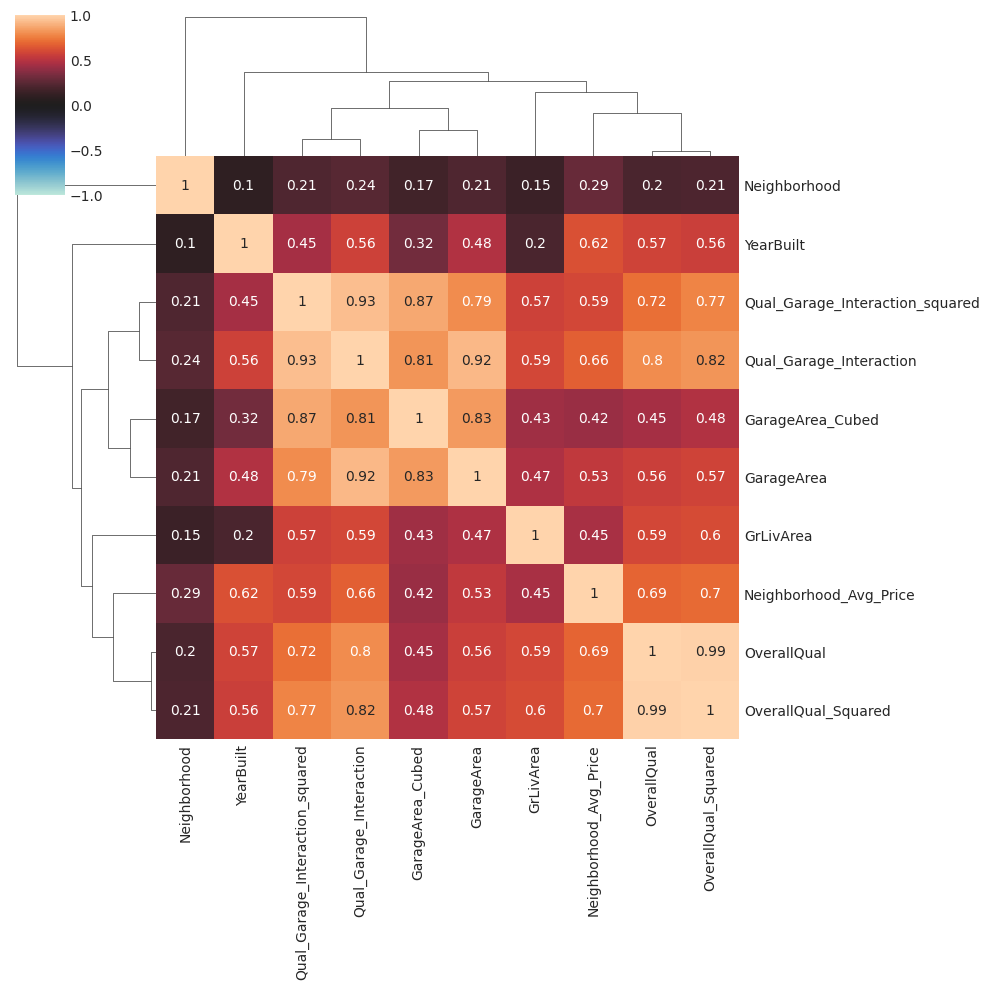

In [79]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method, numeric_only=True),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )

# repasando hacia unas celdas atras, vemos que tenemos las siguientes caracteristicas fundamentales segun nuestro algo. MI:
"""
OverallQual          0.562775
Neighborhood         0.509799
GarageArea           0.496277
GrLivArea            0.431997
YearBuilt            0.409701
...
"""
aux_cols = indices_10_primeros_lista
corrplot(X[aux_cols], annot=True)

In [80]:

"""
viendo la matriz de correlación 
quitaremos las que no están correlacioneadas 
.como neightborhod
.overalqual - evaluamos
.ms subclass no parece existir correlación 
.lot Area
"""

def index_list():

    indices_10_primeros_lista = df_mi_scores.index[:10].tolist()

    print(indices_10_primeros_lista)
    # Elementos a eliminar
    elementos_a_eliminar = ['OverallQual', "Neighborhood", "MSSubClass", "LotArea"]

    # Crear una nueva lista sin los elementos a eliminar
    indices_10_primeros_lista = [x for x in indices_10_primeros_lista if x not in elementos_a_eliminar]

    print(indices_10_primeros_lista)
    # entonces nos quedamos con aquellos que muestrean fuertes correlaciones lineales entre caracteristicas
    return indices_10_primeros_lista

indices_10_primeros_lista = index_list()

['Qual_Garage_Interaction_squared', 'Qual_Garage_Interaction', 'OverallQual', 'OverallQual_Squared', 'Neighborhood_Avg_Price', 'Neighborhood', 'GarageArea_Cubed', 'GarageArea', 'GrLivArea', 'YearBuilt']
['Qual_Garage_Interaction_squared', 'Qual_Garage_Interaction', 'OverallQual_Squared', 'Neighborhood_Avg_Price', 'GarageArea_Cubed', 'GarageArea', 'GrLivArea', 'YearBuilt']


In [81]:
def main5():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    #PCA
    aux_cols = indices_10_primeros_lista
    #     _,X_pca,ññ = apply_pca(X, standardize=False)
    X = X.join(pca_components(X, aux_cols))
    #     X = X.join(X_pca)
    return X, y

# score_dataset
X,y = main5()
score = score_dataset(X,y)
print(score)

# por el momento sigue siendo el mejor "main()"
# quite el puesto 1 de MI (overall) y mejoro un pco la calidad del modelo

0.13799943012645824


PCA transforma tus características originales en un nuevo espacio de características. Las columnas resultantes son las componentes principales, que son combinaciones lineales de las características originales.
Una vez que has transformado los datos con PCA, los datos originales ya no son relevantes para el entrenamiento del modelo, ya que el modelo está entrenando en base a las nuevas características (componentes principales).


después de aplicar PCA y transformar tus datos, debes trabajar solo con los componentes principales para el entrenamiento y la evaluación del modelo. Esto asegura que tu modelo esté utilizando las características reducidas y transformadas adecuadamente y evita problemas relacionados con la redundancia o inconsistencias entre las características originales y las transformadas.

In [82]:
def main6():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    #PCA
    aux_cols = indices_10_primeros_lista
    #     _,X_pca,ññ = apply_pca(X, standardize=False)
    X = X.join(pca_components(X, aux_cols))
#     X = X.drop(columns = aux_cols)
    #     X = X.join(X_pca)
    return X, y

# score_dataset
X,y = main6()
score = score_dataset(X,y)
print(score)


# al eliminar (.drop) las columnas usadas para entrenar al algoritmo de PCA, se perjudica un poco el rendimiento del modelo

# al evaluar el modelo podemos probar con main6 y main4 para ver cual ingenieria de caract. es mejor para la generalizacion del
# modelo

0.13799943012645824


# Utilizamos un encoder mas avanzado, un targetEncoding, basado en cross validation

In [83]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded


def main7():
    df_train, df_test = load_df()
    df_train = impute_none(df_train)
    o = l + h
    df_train = crear_caract(df_train)
    
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    
    df_train = ordinal_encode(df_train, o)
     # Lesson 6 - Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    X = X.join(encoder.fit_transform(X, y, cols= o)) # cols = o son las de alta y baja cardinalidda
    

    indices_10_primeros_lista = index_list()
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    #PCA
    aux_cols = indices_10_primeros_lista
    #     _,X_pca,ññ = apply_pca(X, standardize=False)
    X = X.join(pca_components(X, aux_cols))
    #     X = X.drop(columns = aux_cols)
    #     X = X.join(X_pca)
    return X, y


In [84]:

# score_dataset
X,y = main7()
score = score_dataset(X,y)
print(score)

# el target encoding, en este caso perjudico la calidad del modelo 

['Qual_Garage_Interaction_squared', 'Qual_Garage_Interaction', 'OverallQual', 'OverallQual_Squared', 'Neighborhood_Avg_Price', 'Neighborhood', 'GarageArea_Cubed', 'GarageArea', 'GrLivArea', 'YearBuilt']
['Qual_Garage_Interaction_squared', 'Qual_Garage_Interaction', 'OverallQual_Squared', 'Neighborhood_Avg_Price', 'GarageArea_Cubed', 'GarageArea', 'GrLivArea', 'YearBuilt']
0.1428423311727826


In [85]:
# score_dataset
X,y = main6()
score = score_dataset(X,y)
print(score)

# el target encoding, en este caso perjudico la calidad del modelo 

0.13799943012645824


In [86]:
# score_dataset
X,y = main4()
score = score_dataset(X,y)
print(score)

# el target encoding, en este caso perjudico la calidad del modelo 

0.13687711204063732


In [126]:
df_train, df_test = load_df()
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Creacion del Modelo DL para este problema de prediccion de var. numrica

In [136]:
def main6(verbose = 0):
    df_train, df_test = load_df()
    if verbose != 0 :
        df_t = df_test.copy()
        df_t.pop("SalePrice")
        df_train = pd.concat([df_train, df_t])
        
    df_train = impute_none(df_train)
    o = l + h
    # df_train = one_hot_encode(df_train, l) # nos daría muchas columnas redundantes # dado que la mayoria son de baja cardinalidad
    df_train = ordinal_encode(df_train, o)
    df_train = crear_caract(df_train)
    
    X = df_train
    y = df_train.pop('SalePrice')
    
    mi_scores = make_mi_scores(X, y)
    X = drop_uninformative(X, mi_scores)
    
    mi_scores = make_mi_scores(X, y)
    #PCA
    aux_cols = indices_10_primeros_lista
    #     _,X_pca,ññ = apply_pca(X, standardize=False)
    X = X.join(pca_components(X, aux_cols))
#     X = X.drop(columns = aux_cols)
    #     X = X.join(X_pca)
    return X, y

# score_dataset
X,y = main6()
score = score_dataset(X,y)
print(score)


# score_dataset
X,y, X_test, y_test = main6()
score = score_dataset(X,y)
print(score)

0.13799943012645824


ValueError: not enough values to unpack (expected 4, got 2)

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Graficar el entrenamiento del modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Loss (entrenamiento)')
    plt.plot(history.history['val_loss'], label='Loss (validación)')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Historial de entrenamiento')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    def plot_training_history(history):
        plt.figure(figsize=(12, 8))

        # Graficar MSE
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='MSE (entrenamiento)')
        plt.plot(history.history['val_loss'], label='MSE (validación)')
        plt.xlabel('Época')
        plt.ylabel('MSE')
        plt.title('Historial de MSE')
        plt.legend()
        plt.grid(True)

        # Graficar MAE
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='MAE (entrenamiento)')
        plt.plot(history.history['val_mae'], label='MAE (validación)')
        plt.xlabel('Época')
        plt.ylabel('MAE')
        plt.title('Historial de MAE')
        plt.legend()
        plt.grid(True)
        
    plot_training_history(history)
    
    
def plot_metrics_history(history, metric='mse'):
    #es útil visualizar cómo cambian estas métricas a lo largo del tiempo.
    plt.figure(figsize=(12, 8))
    plt.plot(history.history[metric], label=f'{metric} (entrenamiento)')
    plt.plot(history.history[f'val_{metric}'], label=f'{metric} (validación)')
    plt.xlabel('Época')
    plt.ylabel(metric)
    plt.title(f'Historial de {metric}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred
    plt.figure(figsize=(12, 8))
    plt.hist(errors, bins=50, color='blue', edgecolor='black')
    plt.xlabel('Error')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de Errores')
    plt.grid(True)
    plt.show()
    
def plot_predictions_vs_true(y_true, y_pred):
    plt.figure(figsize=(12, 8))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs. Valores Reales')
    plt.grid(True)
    plt.show()


# Crear un modelo secuencial
def create_model(X_train, DENSE=100, LAYERS=4, DROPOUT=0.15, L2=0.01, learning_rate=0.0001):
    model = Sequential()
    # Añadir la primera capa con la dimensión de entrada
    model.add(Dense(DENSE, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(DROPOUT))
    
    # Añadir capas ocultas según el parámetro LAYERS
    for _ in range(LAYERS):
#         model.add(Dense(DENSE, activation='relu', kernel_regularizer=l2(L2)))
        model.add(Dense(DENSE, activation='relu'))
        model.add(Dropout(DROPOUT))
        
    # Añadir la capa de salida
    model.add(Dense(1))
    
    # Definir el optimizador con el learning rate especificado
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compilar el modelo
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])
    
    return model

Epoch 1/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 100868707844096.0000 - mae: 3648660.5000 - mse: 100868707844096.0000 - val_loss: 2738922979328.0000 - val_mae: 1009129.8750 - val_mse: 2738922979328.0000 - learning_rate: 0.0010
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10535026294784.0000 - mae: 1610856.6250 - mse: 10535026294784.0000 - val_loss: 37775450112.0000 - val_mae: 156461.7188 - val_mse: 37775450112.0000 - learning_rate: 0.0010
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5662942691328.0000 - mae: 1075392.2500 - mse: 5662942691328.0000 - val_loss: 249988677632.0000 - val_mae: 207210.3750 - val_mse: 249988677632.0000 - learning_rate: 0.0010
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4097346371584.0000 - mae: 952093.5000 - mse: 4097346371584.0000 - val_loss: 72409358336.0000 - val_mae: 145469.6094 - val_mse: 72409358336.0000 - learning_rate: 0.0010
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2546997395456.00

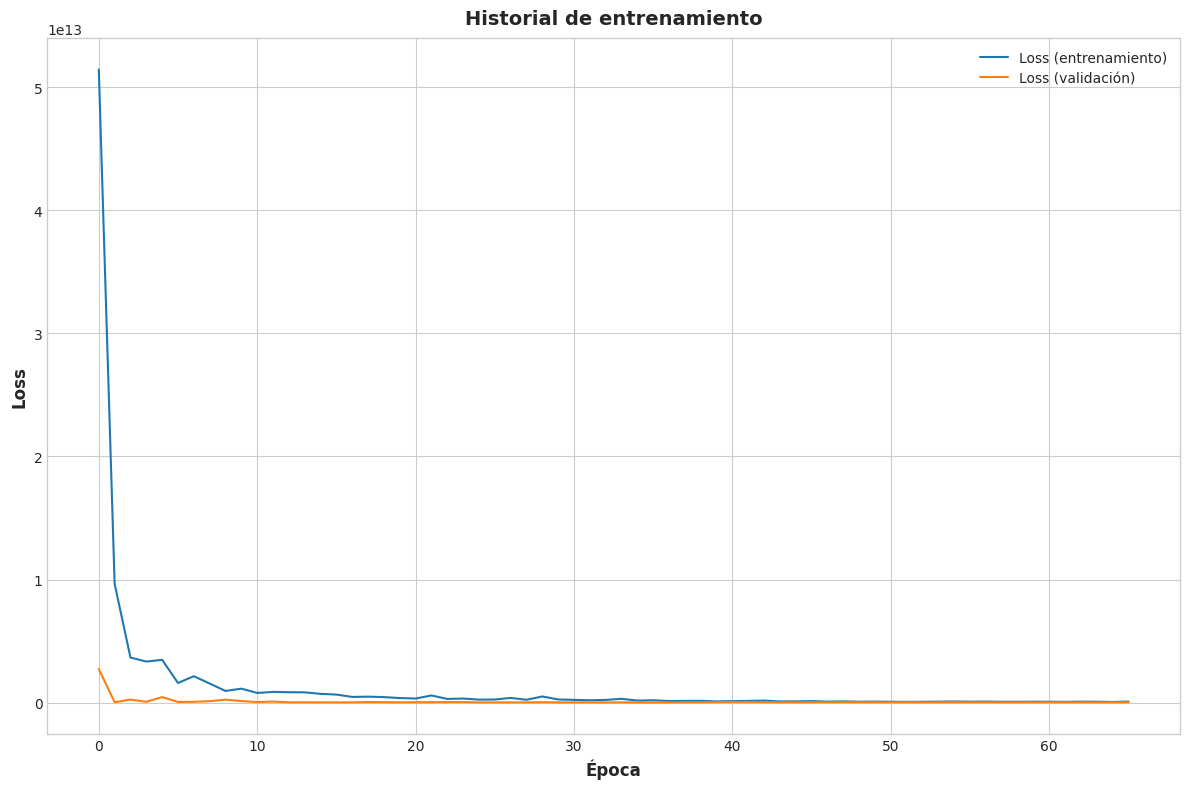

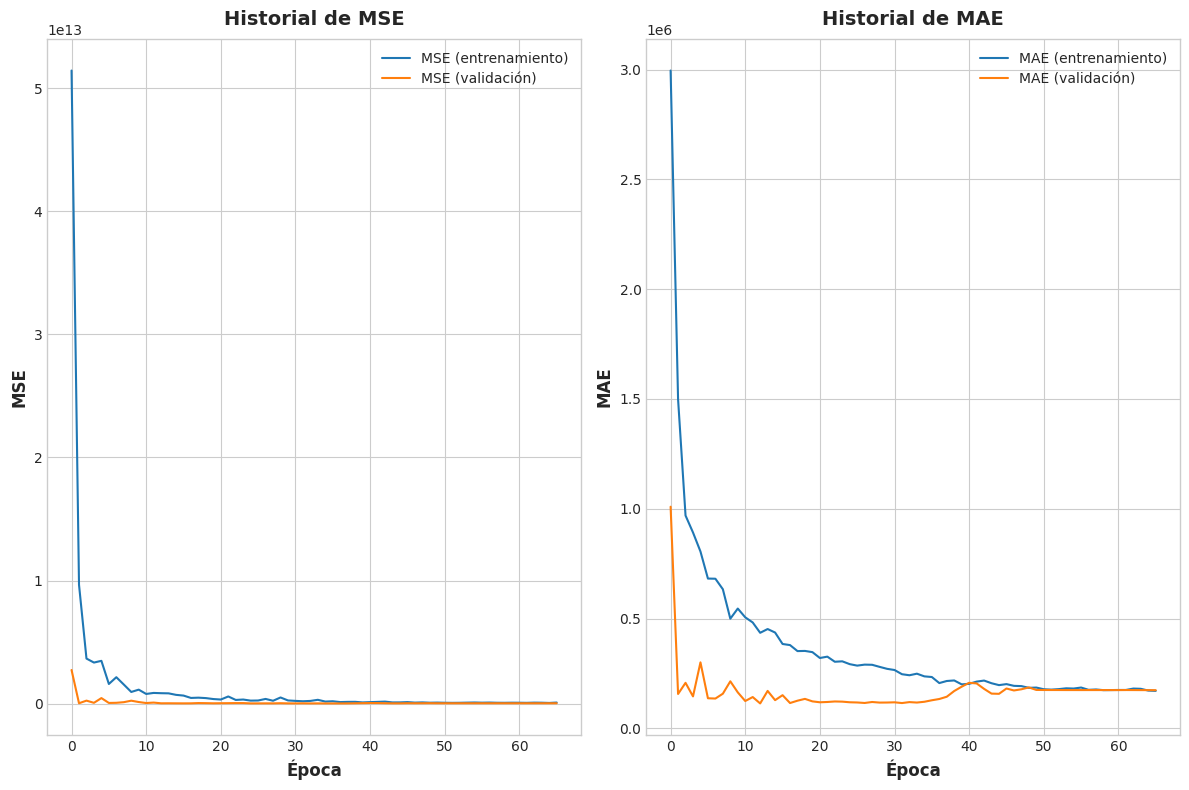

In [121]:
# Dividimos los datos
# X_train, X_valid, y_train, y_valid, X_test, y_test = obtener_datos_reg(X,y)

X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size = 0.8)

# Crear y compilar el modelo
model = create_model(X_train, DENSE=150, LAYERS=4, DROPOUT=0.2, L2=0.01, learning_rate=0.001)

# Definir los callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=15, min_lr=1e-6)

# Entrenar el modelo y guardar el historial
history = model.fit(
    X_train,y_train,
    epochs=200,
    batch_size=75,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping, reduce_lr]
)

""" Callbacks muy utiles:
EarlyStopping: Detiene el entrenamiento cuando el modelo deja de mejorar en la métrica monitoreada.
ReduceLROnPlateau: Reduce la tasa de aprendizaje cuando una métrica ha dejado de mejorar.

EarlyStopping:

monitor='val_loss': Monitorea la pérdida de validación.
patience=10: Si no hay mejora en 10 épocas, detiene el entrenamiento.
restore_best_weights=True: Restaura los pesos del modelo en la mejor época de validación.
ReduceLROnPlateau:

monitor='val_loss': Monitorea la pérdida de validación.
factor=0.1: Reduce la tasa de aprendizaje en un factor de 10.
patience=5: Si no hay mejora en 5 épocas, reduce la tasa de aprendizaje.
min_lr=1e-6: Establece el valor mínimo para la tasa de aprendizaje.
Entrenamiento:

validation_data=(X_valid, y_valid): Utiliza los datos de validación durante el entrenamiento.
callbacks=[early_stopping, reduce_lr]: Añade los callbacks al entrenamiento.

mas : 
>> El regularizador L2, también conocido como Ridge Regularization o Penalización de Normas L2, añade una penalización al tamaño de los pesos en el modelo
"""

# Llamar a la función para graficar el historial de entrenamiento
plot_training_history(history)



In [106]:
# Evaluar el modelo en el conjunto de datos de prueba
mae = model.evaluate(X_test, y_test, verbose=1)

# print(f'Loss en el conjunto de prueba: {loss}')
print(f'MAE en el conjunto de prueba: {mae}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16130456576.0000 - mae: 101325.4062 - mse: 16130456576.0000
MAE en el conjunto de prueba: [18275731456.0, 101944.2421875, 18275731456.0]


In [135]:
import numpy as np
import pandas as pd

# Realizar la predicción
predictions = model.predict(X_valid)

predictions
final_pipeline = model
#     final_pipeline.fit(X_train, y_train)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate on the test set
test_preds = predictions
test_r2 = r2_score(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))

print("Test R^2 : ", test_r2)
print("Test MAE : ", test_mae)
print("Test RMSE : ", test_rmse)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Test R^2 :  -2.685545929048492
Test MAE :  129889.31056937126
Test RMSE :  162126.81726832147


# Este modelo no es practico ni util, lo mejor es entrenar un xgboost y de esa manera si es util la prediccion (y a posterior usar optuna para un tunning de hyperparametros). 

# Lo importante en este caso practico fue el aplicar la  ingenieria de caracteristicas que vimos en el curso previamente visto.

# Mas adelante practicare mas y mas con tf. para resolver mas tipos de problemas.

In [ ]:
# Aplanar el array de predicciones
predictions = predictions.flatten()



# Crear el DataFrame
output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})

# Guardar la salida en un archivo CSV
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [90]:
# ESTA CELDA DA ERROR POR EL STANDARD SCALER # ademas no conviene porque estariamos mod. el año, deberiamos de ser mas especificos

# def standardize_features(df, numeric_cols=None):
#     # Identificar las columnas numéricas
#     if numeric_cols is None:
#         print("se necesita lista de nombres de columna 'n' como parametro")
    
#     # Crear un objeto StandardScaler
#     scaler = StandardScaler()
    
#     # Ajustar y transformar las columnas numéricas
#     df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    
#     return df

# def main2():
#     df_train, df_test = load_df()
#     df_train = one_hot_encode(df_train, l)
#     df_train = ordinal_encode(df_train, h)
#     df_train = standardize_features(df_train, n) # da un error 
#     X = df_train
#     y = df_train.pop('SalePrice')
#     return X, y

# X,y = main2()
# score = score_dataset(X,y)
# print(score)